## Autoencoder

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

# Definir el modelo AutoEncoder
class AutoEncoder(nn.Module):
    def __init__(self, input_shape_pov):
        super(AutoEncoder, self).__init__()
        self.input_shape_pov = input_shape_pov

        # Codificador
        self.encoder = nn.Sequential(
            nn.Conv3d(input_shape_pov[0], 32, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Conv3d(32, 64, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Conv3d(64, 128, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Conv3d(128, 256, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 1, 1))
        )

        # Decodificador
        self.decoder = nn.Sequential(
            nn.Conv3d(256, 256, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Upsample(scale_factor=(1, 2, 2), mode='trilinear', align_corners=True),
            nn.Conv3d(256, 128, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Upsample(scale_factor=(1, 2, 2), mode='trilinear', align_corners=True),
            nn.Conv3d(128, 64, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Upsample(scale_factor=(1, 2, 2), mode='trilinear', align_corners=True),
            nn.Conv3d(64, 32, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Upsample(scale_factor=(1, 2, 2), mode='trilinear', align_corners=True),
            nn.Conv3d(32, 3, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # Ajustar las dimensiones para recortar
        decoded = decoded[:, :, :, :188, :260]
        return encoded, decoded

## Dataset

### Preprocesamiento con los datos nuevos

In [1]:
from sklearn.utils import class_weight
import ast
import numpy as np
import math
import cv2
from PIL import Image, ImageEnhance ,ImageFilter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import logging

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
FILAS_MAX = 30

def cargar_df(archivo,filas_max):
    # Cargar el DataFrame desde un archivo .pkl
    df = pd.read_pickle(archivo)
    # Encontrar el valor máximo de la columna 'orden' para cada 'id'
    maximos_orden_por_id = df.groupby('id')['orden'].max()

    # Filtrar los 'id' cuyo valor máximo de 'orden' es mayor a filas_max
    ids_mayor_30 = maximos_orden_por_id[maximos_orden_por_id > filas_max].index.tolist()

    return df[~df['id'].isin(ids_mayor_30)] #Eliminamos todos los que su orden en mayor de 30

def preprocesado_df(df):
    # Convertir la columna de tipo object a listas de enteros
    df['etiqueta'] = df['etiqueta'].apply(ast.literal_eval)
    # Eliminamos las filas donde 'mouse_final' sea igual a [0, 4]
    filtro = df['etiqueta'].apply(lambda x: x[1] == 4)
    df = df[~filtro]
    # Crear un filtro booleano para las filas que cumplen la condición
    condicion = df['etiqueta'].apply(lambda x: x[1] == 2)
    # Juntamos las pulsaciones y tecla en una columna
    #x_positions_2 = df['etiqueta'].apply(lambda x: str(x[0])+str(x[1]))
    x_positions_2 = df['etiqueta'].apply(lambda x: str(x[1]))
    df['etiqueta'] = x_positions_2
    # Modificar solo las filas que cumplen con la condición
    #df.loc[condicion, 'etiqueta'] = df.loc[condicion, 'etiqueta'].apply(lambda x: "12")
    return df

def aplicar_one_hot_balanceo(df,columa):
    # Crear un DataFrame con las columnas de one-hot encoding
    one_hot_df = pd.get_dummies(df[columa], prefix='label')

    # Unir el DataFrame original con el DataFrame de one-hot encoding
    df = pd.concat([df, one_hot_df], axis=1)

    # Balanceamos los pesos para el entrenamiento
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df[columa]),
        y=df[columa]
    )

    # Crear un diccionario de pesos para las clases
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    #Eliminamos la columna original
    df = df.drop(columa, axis=1)
    return df , class_weight_dict

In [3]:
df = cargar_df('df_augementado.pkl',FILAS_MAX)
df , pesos_train = aplicar_one_hot_balanceo(preprocesado_df(df),"etiqueta")

/tmp/ipykernel_7393/1564318661.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['etiqueta'] = x_positions_2


In [4]:
def reordenar_id(df):
    # Crear un diccionario de mapeo de los IDs actuales a los nuevos consecutivos
    # Primero, obtenemos los valores únicos de ID y les asignamos nuevos valores consecutivos
    nuevos_ids = {old_id: new_id for new_id, old_id in enumerate(sorted(df['id'].unique()))}
    # Aplicamos el mapeo para reemplazar los IDs en el DataFrame
    df['id'] = df['id'].map(nuevos_ids)
    df = df.reset_index(drop=True)
    return df

In [5]:
df = reordenar_id(df)

In [6]:
# Filtrar las filas donde el ID esté entre 3586 y 3596 (inclusive)
filtered_df = df[(df['id'] >= 3576) & (df['id'] <= 3596)]

In [7]:
filtered_df

id orden                                            mapa_01  \
46589  3576     1  datos/grabacion/mapa_augmentation/imagen_14427...   
46590  3576     2  datos/grabacion/mapa_augmentation/imagen_14428...   
46591  3576     3  datos/grabacion/mapa_augmentation/imagen_14429...   
46592  3576     4  datos/grabacion/mapa_augmentation/imagen_14430...   
46593  3576     5  datos/grabacion/mapa_augmentation/imagen_14431...   
...     ...   ...                                                ...   
46877  3596     2  datos/grabacion/mapa_augmentation/imagen_14808...   
46878  3596     3  datos/grabacion/mapa_augmentation/imagen_14809...   
46879  3596     4  datos/grabacion/mapa_augmentation/imagen_14810...   
46880  3596     5  datos/grabacion/mapa_augmentation/imagen_14811...   
46881  3596     6  datos/grabacion/mapa_augmentation/imagen_14812...   

                                                 mapa_02  \
46589  datos/grabacion/mapa_augmentation/imagen_14427...   
46590  datos/grabacion/mapa_augmentation/imagen_14428...   
46591  datos/grabacion/mapa_augmentation/imagen_14429...   
46592  datos/grabacion/mapa_augmentation/imagen_14430...   
46593  datos/grabacion/mapa_augmentation/imagen_14431...   
...                                                  ...   
46877  datos/grabacion/mapa_augmentation/imagen_14808...   
46878  datos/grabacion/mapa_augmentation/imagen_14809...   
46879  datos/grabacion/mapa_augmentation/imagen_14810...   
46880  datos/grabacion/mapa_augmentation/imagen_14811...   
46881  datos/grabacion/mapa_augmentation/imagen_14812...   

                                                 mapa_03  \
46589  datos/grabacion/mapa_augmentation/imagen_14427...   
46590  datos/grabacion/mapa_augmentation/imagen_14428...   
46591  datos/grabacion/mapa_augmentation/imagen_14429...   
46592  datos/grabacion/mapa_augmentation/imagen_14430...   
46593  datos/grabacion/mapa_augmentation/imagen_14431...   
...                                                  ...   
46877  datos/grabacion/mapa_augmentation/imagen_14808...   
46878  datos/grabacion/mapa_augmentation/imagen_14809...   
46879  datos/grabacion/mapa_augmentation/imagen_14810...   
46880  datos/grabacion/mapa_augmentation/imagen_14811...   
46881  datos/grabacion/mapa_augmentation/imagen_14812...   

                                                 mapa_04  \
46589  datos/grabacion/mapa_augmentation/imagen_14427...   
46590  datos/grabacion/mapa_augmentation/imagen_14428...   
46591  datos/grabacion/mapa_augmentation/imagen_14429...   
46592  datos/grabacion/mapa_augmentation/imagen_14430...   
46593  datos/grabacion/mapa_augmentation/imagen_14431...   
...                                                  ...   
46877  datos/grabacion/mapa_augmentation/imagen_14808...   
46878  datos/grabacion/mapa_augmentation/imagen_14809...   
46879  datos/grabacion/mapa_augmentation/imagen_14810...   
46880  datos/grabacion/mapa_augmentation/imagen_14811...   
46881  datos/grabacion/mapa_augmentation/imagen_14812...   

                                                 mapa_05  reward  label_0  \
46589  datos/grabacion/mapa_augmentation/imagen_14427...   0.965        0   
46590  datos/grabacion/mapa_augmentation/imagen_14428...   0.540        0   
46591  datos/grabacion/mapa_augmentation/imagen_14429...   0.560        1   
46592  datos/grabacion/mapa_augmentation/imagen_14430...   0.605        0   
46593  datos/grabacion/mapa_augmentation/imagen_14431...   0.605        0   
...                                                  ...     ...      ...   
46877  datos/grabacion/mapa_augmentation/imagen_14808...   0.885        0   
46878  datos/grabacion/mapa_augmentation/imagen_14809...   0.425        0   
46879  datos/grabacion/mapa_augmentation/imagen_14810...   0.545        0   
46880  datos/grabacion/mapa_augmentation/imagen_14811...   0.545        0   
46881  datos/grabacion/mapa_augmentation/imagen_14812...   0.605        0   

       label_1  label_2  
46589        1        0  
4659

In [8]:
# Eliminar esas filas del DataFrame original
df_train = df.drop(df[(df['id'] >= 3576) & (df['id'] <= 3596)].index)
# Reiniciar el índice del train
df_train = df_train.reset_index(drop=True)
# Reiniciar el índice del valid
filtered_df = filtered_df.reset_index(drop=True)

In [9]:
filtered_df = reordenar_id(filtered_df)

In [10]:
filtered_df

id orden                                            mapa_01  \
0     0     1  datos/grabacion/mapa_augmentation/imagen_14427...   
1     0     2  datos/grabacion/mapa_augmentation/imagen_14428...   
2     0     3  datos/grabacion/mapa_augmentation/imagen_14429...   
3     0     4  datos/grabacion/mapa_augmentation/imagen_14430...   
4     0     5  datos/grabacion/mapa_augmentation/imagen_14431...   
..   ..   ...                                                ...   
288  20     2  datos/grabacion/mapa_augmentation/imagen_14808...   
289  20     3  datos/grabacion/mapa_augmentation/imagen_14809...   
290  20     4  datos/grabacion/mapa_augmentation/imagen_14810...   
291  20     5  datos/grabacion/mapa_augmentation/imagen_14811...   
292  20     6  datos/grabacion/mapa_augmentation/imagen_14812...   

                                               mapa_02  \
0    datos/grabacion/mapa_augmentation/imagen_14427...   
1    datos/grabacion/mapa_augmentation/imagen_14428...   
2    datos/grabacion/mapa_augmentation/imagen_14429...   
3    datos/grabacion/mapa_augmentation/imagen_14430...   
4    datos/grabacion/mapa_augmentation/imagen_14431...   
..                                                 ...   
288  datos/grabacion/mapa_augmentation/imagen_14808...   
289  datos/grabacion/mapa_augmentation/imagen_14809...   
290  datos/grabacion/mapa_augmentation/imagen_14810...   
291  datos/grabacion/mapa_augmentation/imagen_14811...   
292  datos/grabacion/mapa_augmentation/imagen_14812...   

                                               mapa_03  \
0    datos/grabacion/mapa_augmentation/imagen_14427...   
1    datos/grabacion/mapa_augmentation/imagen_14428...   
2    datos/grabacion/mapa_augmentation/imagen_14429...   
3    datos/grabacion/mapa_augmentation/imagen_14430...   
4    datos/grabacion/mapa_augmentation/imagen_14431...   
..                                                 ...   
288  datos/grabacion/mapa_augmentation/imagen_14808...   
289  datos/grabacion/mapa_augmentation/imagen_14809...   
290  datos/grabacion/mapa_augmentation/imagen_14810...   
291  datos/grabacion/mapa_augmentation/imagen_14811...   
292  datos/grabacion/mapa_augmentation/imagen_14812...   

                                               mapa_04  \
0    datos/grabacion/mapa_augmentation/imagen_14427...   
1    datos/grabacion/mapa_augmentation/imagen_14428...   
2    datos/grabacion/mapa_augmentation/imagen_14429...   
3    datos/grabacion/mapa_augmentation/imagen_14430...   
4    datos/grabacion/mapa_augmentation/imagen_14431...   
..                                                 ...   
288  datos/grabacion/mapa_augmentation/imagen_14808...   
289  datos/grabacion/mapa_augmentation/imagen_14809...   
290  datos/grabacion/mapa_augmentation/imagen_14810...   
291  datos/grabacion/mapa_augmentation/imagen_14811...   
292  datos/grabacion/mapa_augmentation/imagen_14812...   

                                               mapa_05  reward  label_0  \
0    datos/grabacion/mapa_augmentation/imagen_14427...   0.965        0   
1    datos/grabacion/mapa_augmentation/imagen_14428...   0.540        0   
2    datos/grabacion/mapa_augmentation/imagen_14429...   0.560        1   
3    datos/grabacion/mapa_augmentation/imagen_14430...   0.605        0   
4    datos/grabacion/mapa_augmentation/imagen_14431...   0.605        0   
..                                                 ...     ...      ...   
288  datos/grabacion/mapa_augmentation/imagen_14808...   0.885        0   
289  datos/grabacion/mapa_augmentation/imagen_14809...   0.425        0   
290  datos/grabacion/mapa_augmentation/imagen_14810...   0.545        0   
291  datos/grabacion/mapa_augmentation/imagen_14811...   0.545        0   
292  datos/grabacion/mapa_augmentation/imagen_14812...   0.605        0   

     label_1  label_2  
0          1        0  
1          0        1  
2          0        0  
3          0        1  
4          1        0  
..       ...      ...  
288        0        1  
289 

0.845
0.7150000000000001
0.78
0.765
0.775
0.87
0.925
0.92


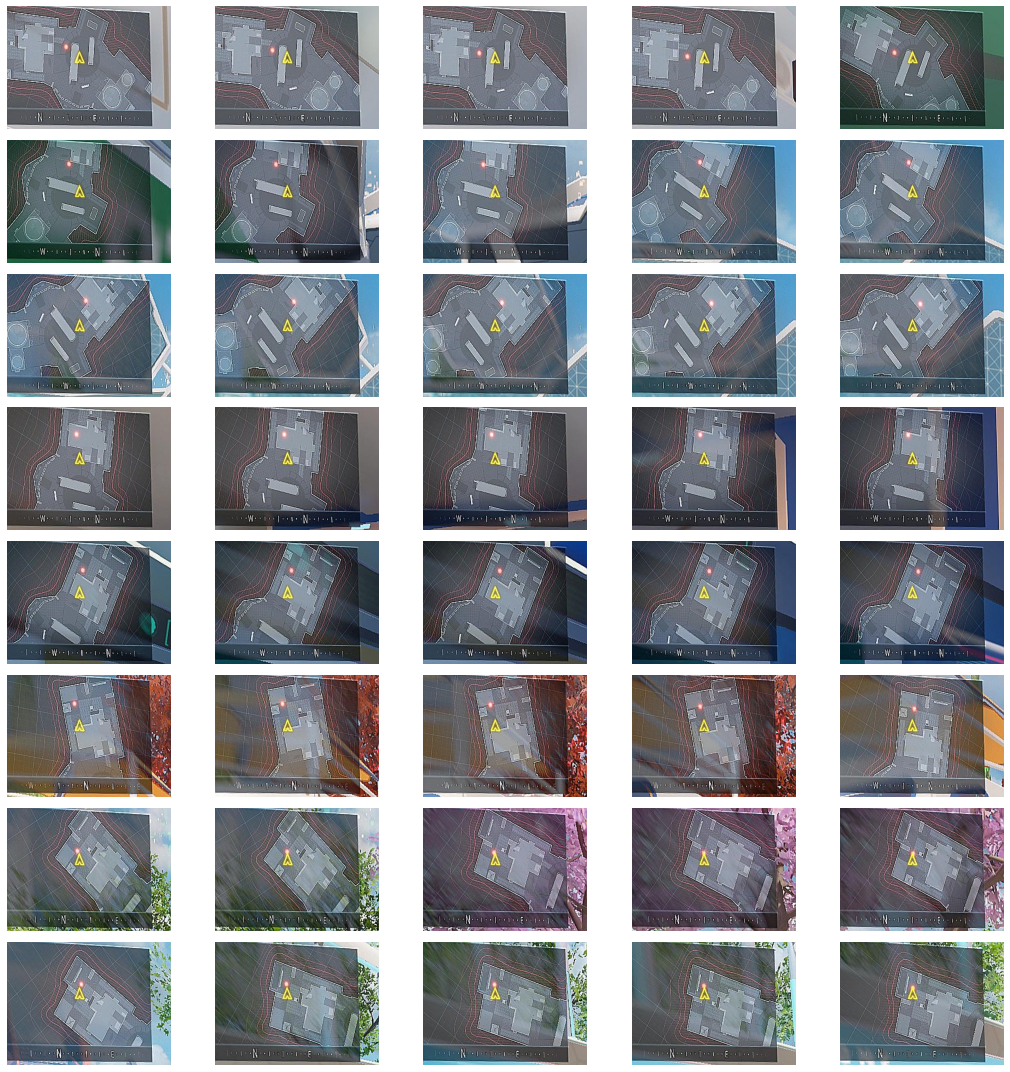

In [11]:
import matplotlib.pyplot as plt

posicion_x = 8
filas = 8
df_mostrar = filtered_df

fig, axes = plt.subplots(filas, 5, figsize=(15, 15))

for i in range(filas):
    for j in range(5):
        # Obtener la ruta de la imagen
        ruta_imagen = df_mostrar.iloc[(posicion_x+i), (j+2)]  # Usamos j+2 para compensar el cambio de rango

        # Abrir la imagen y convertirla a matriz numpy
        imagen = Image.open("../" + ruta_imagen)
        matriz_np = np.array(imagen)

        # Mostrar la imagen en el subplot correspondiente
        axes[i, j].imshow(matriz_np)
        axes[i, j].axis('off')
    print(df_mostrar.at[(posicion_x+i), "reward"])

plt.tight_layout()
plt.show()


In [12]:
df_train

id orden                                            mapa_01  \
0         0     1  datos/grabacion/mini_mapa/mini_mapa_07-20-03-2...   
1         0     2  datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   
2         0     3  datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   
3         0     4  datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   
4         0     5  datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   
...     ...   ...                                                ...   
46584  3575     3  datos/grabacion/mapa_augmentation/imagen_14421...   
46585  3575     4  datos/grabacion/mapa_augmentation/imagen_14422...   
46586  3575     5  datos/grabacion/mapa_augmentation/imagen_14423...   
46587  3575     6  datos/grabacion/mapa_augmentation/imagen_14424...   
46588  3575     7  datos/grabacion/mapa_augmentation/imagen_14425...   

                                                 mapa_02  \
0      datos/grabacion/mini_mapa/mini_mapa_07-20-03-2...   
1      datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   
2      datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   
3      datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   
4      datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   
...                                                  ...   
46584  datos/grabacion/mapa_augmentation/imagen_14421...   
46585  datos/grabacion/mapa_augmentation/imagen_14422...   
46586  datos/grabacion/mapa_augmentation/imagen_14423...   
46587  datos/grabacion/mapa_augmentation/imagen_14424...   
46588  datos/grabacion/mapa_augmentation/imagen_14425...   

                                                 mapa_03  \
0      datos/grabacion/mini_mapa/mini_mapa_07-20-03-2...   
1      datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   
2      datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   
3      datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   
4      datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   
...                                                  ...   
46584  datos/grabacion/mapa_augmentation/imagen_14421...   
46585  datos/grabacion/mapa_augmentation/imagen_14422...   
46586  datos/grabacion/mapa_augmentation/imagen_14423...   
46587  datos/grabacion/mapa_augmentation/imagen_14424...   
46588  datos/grabacion/mapa_augmentation/imagen_14425...   

                                                 mapa_04  \
0      datos/grabacion/mini_mapa/mini_mapa_07-20-03-2...   
1      datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   
2      datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   
3      datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   
4      datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   
...                                                  ...   
46584  datos/grabacion/mapa_augmentation/imagen_14421...   
46585  datos/grabacion/mapa_augmentation/imagen_14422...   
46586  datos/grabacion/mapa_augmentation/imagen_14423...   
46587  datos/grabacion/mapa_augmentation/imagen_14424...   
46588  datos/grabacion/mapa_augmentation/imagen_14425...   

                                                 mapa_05  reward  label_0  \
0      datos/grabacion/mini_mapa/mini_mapa_07-20-03-2...   0.580        0   
1      datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   0.565        0   
2      datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   0.715        1   
3      datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   0.785        0   
4      datos/grabacion/mini_mapa/mini_mapa_07-20-03-3...   0.675        0   
...                                                  ...     ...      ...   
46584  datos/grabacion/mapa_augmentation/imagen_14421...   0.515        0   
46585  datos/grabacion/mapa_augmentation/imagen_14422...   0.535        0   
46586  datos/grabacion/mapa_augmentation/imagen_14423...   0.865        0   
46587  datos/grabacion/mapa_augmentation/imagen_14424...   0.550        0   
46588  datos/grabacion/mapa_augmentation/imagen_14425...   0.740        1   

       label_1  label_2  
0            0        1  
1   

In [13]:
df_train[df_train['id'] == 5]

id orden                                            mapa_01  \
111   5     0  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
112   5     1  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
113   5     2  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
114   5     3  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
115   5     4  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
116   5     5  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
117   5     6  datos/grabacion/mini_mapa/mini_mapa_07-20-06-3...   
118   5     7  datos/grabacion/mini_mapa/mini_mapa_07-20-06-3...   

                                               mapa_02  \
111  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
112  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
113  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
114  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
115  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
116  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
117  datos/grabacion/mini_mapa/mini_mapa_07-20-06-3...   
118  datos/grabacion/mini_mapa/mini_mapa_07-20-06-3...   

                                               mapa_03  \
111  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
112  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
113  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
114  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
115  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
116  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
117  datos/grabacion/mini_mapa/mini_mapa_07-20-06-3...   
118  datos/grabacion/mini_mapa/mini_mapa_07-20-06-3...   

                                               mapa_04  \
111  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
112  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
113  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
114  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
115  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
116  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   
117  datos/grabacion/mini_mapa/mini_mapa_07-20-06-3...   
118  datos/grabacion/mini_mapa/mini_mapa_07-20-06-3...   

                                               mapa_05  reward  label_0  \
111  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   0.955        0   
112  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   0.935        1   
113  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   0.635        0   
114  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   0.890        0   
115  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   0.930        0   
116  datos/grabacion/mini_mapa/mini_mapa_07-20-06-2...   0.630        1   
117  datos/grabacion/mini_mapa/mini_mapa_07-20-06-3...   0.630        0   
118  datos/grabacion/mini_mapa/mini_mapa_07-20-06-3...   0.675        0   

     label_1  label_2  
111        0        1  
112        0        0  
113        1        0  
114        0        1  
115        0        1  
116        0        0  
117        0        1  
118        1        0

In [14]:
print(df['id'].max())
print(filtered_df['id'].max())

3596
20


### Dataloader

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader

class PyTorchImageDataset2(Dataset):
    def __init__(self, df, sequence_length, image_height, image_width , model, max_ep_len ,encoder=None, pov=False):
        self.df = df
        self.sequence_length = sequence_length
        self.image_height = image_height
        self.image_width = image_width
        self.modelo = model
        self.max_ep_len = max_ep_len
        self.encoder_entrenado = encoder
        self.pov = pov  # Variable para POV

    def _precedecir_aplanar(self,video_tensor):
        self.modelo.eval()
        # Generar la salida
        with torch.no_grad():
            # Convertir los arrays de NumPy a tensores de PyTorch
            input_images = torch.tensor(video_tensor, dtype=torch.float32)
            input_images = input_images.to('cuda').float()  # Mover a GPU
            features, _ = self.modelo(input_images)
            return features.reshape(features.size(0), -1) #Flatten()
    
    def _agregar_padding(self,tensor):
        """
        Rellenamos de padding los tensores hasta culmplir las dimensiones de entrada
        
        """
        
        # rellenamos un tensor de las dimensiones faltantes vacio
        rellenar_vacio = (self.max_ep_len - tensor.shape[0])

        if tensor.ndim == 2:
            # Creamos un tensor de 0s respetando el tamaño del features
            padding_tensor = torch.zeros(rellenar_vacio, tensor.shape[1], device=tensor.device)
        elif tensor.ndim == 1:
            # Creamos un tensor de 0s
            padding_tensor = torch.zeros(rellenar_vacio, device=tensor.device)
        # Concatenar el tensor original con el de relleno
        tensor_rellenado = torch.cat((tensor, padding_tensor), dim=0)

        return tensor_rellenado

    def _crear_attention_mask(self,tamano_original):
        """
        Crea una máscara de atención para un tensor rellenado.
        
        """
        # Crear una máscara con 1s para los datos reales
        attention_mask = torch.zeros(self.max_ep_len, dtype=torch.float32)
        attention_mask[:tamano_original] = 1  # Marcar como "válido" las posiciones reales
        return attention_mask
    

    def __len__(self):
        return self.df['id'].nunique()
    
    def _relleno_intermitente(self,tensor, max_posicion):
        # Recorrer el tensor hasta la posición
        for i in range(max_posicion):  # Hasta la posición 19 (incluyendo 0)
            if i % 2 == 0:  # Si la posición es par
                tensor[i] = torch.zeros(tensor[i].size())  # Agregar todo 0 como contenido
        
        return tensor.to('cuda')

    def __getitem__(self, index):
        # Filtrar las filas donde la columna 'id' es igual a 'id_value'
        rows = self.df[self.df['id'] == index]

        videos = []  # Lista para almacenar los videos procesados
        etiquetas = []  # Lista para almacenar las etiquetas
        rewards = []  # Lista para almacenar los rewards

        for _, row in rows.iterrows():  # Iterar sobre cada fila que cumple la condición
            # Inicializar matriz para un video
            video = np.zeros((self.sequence_length, self.image_height, self.image_width, 3))  # (T, H, W, C)

            for j in range(self.sequence_length):
                # Cargar imagen
                imagen = Image.open("../" + row.iloc[j + 2])  # Obtener la ruta de la imagen
                imagen = imagen.resize((self.image_width, self.image_height))  # Redimensionar a (ancho, alto)
                ancho, alto = imagen.size

                # Aplicar transformaciones si POV es True
                if self.pov:
                    imagen = imagen.rotate(2.5, expand=True)
                    imagen = imagen.crop((5, 12, ancho - 35, alto - 25))
                    imagen = ImageEnhance.Sharpness(imagen)
                    imagen = imagen.enhance(7)

                # Normalizar la imagen
                imagen = np.array(imagen) / 255.0
                video[j] = imagen  # Añadir el frame al video

            # Obtener el video
            video_tensor = torch.tensor(video, dtype=torch.float32)
            video_tensor = video_tensor.unsqueeze(0)  # Ahora tendrá forma (1, T, H, W, C)
            video_tensor = video_tensor.permute(0, 4, 1, 2, 3)  # Reorganizar las dimensiones
            video_tensor = video_tensor.to('cuda').float()
            videos.append(self._precedecir_aplanar(video_tensor))

            # Obtener etiquetas (columnas que comienzan con 'label')
            y_batch = row.filter(like='label').values
            y_batch = np.array(y_batch, dtype=np.float32)  # One-hot está en formato binario,
            y_tensor = torch.tensor(y_batch, dtype=torch.float32).to('cuda')
            etiquetas.append(y_tensor)

            # Obtener el reward
            reward = torch.tensor(row['reward'], dtype=torch.float32).to('cuda')  # Convertir y mover a GPU
            rewards.append(reward)

        # Convertir las listas de videos y etiquetas a tensores
        features_tensor = torch.cat(videos, dim=0).to('cuda')  # Concatenar y mover a GPU
        etiquetas_tensor = torch.stack(etiquetas).to('cuda')  # Apilar y mover a GPU
        rewards_tensor = torch.stack(rewards).to('cuda')  # Apilar y mover a GPU

        #Aplicamos el padding
        padding_features = self._agregar_padding(features_tensor)
        padding_target = self._agregar_padding(etiquetas_tensor)
        padding_reward = self._agregar_padding(rewards_tensor)

        ##mask attention
        real_size = features_tensor.shape[0]
        attention_mask = self._crear_attention_mask(real_size)

        return self._relleno_intermitente(padding_features,real_size), self._relleno_intermitente(padding_target,real_size) ,self._relleno_intermitente(padding_reward,real_size), self._relleno_intermitente(attention_mask,real_size),real_size

In [17]:
# Cargar modelo autoencoder
input_shape_pov = (3, 5, 188, 260)  # Ejemplo de forma de entrada (canales, pasos de tiempo, alto, ancho)
model = AutoEncoder(input_shape_pov).to('cuda')  # Instancia el modelo y lo envía a la GPU
model.load_state_dict(torch.load('modelo_autoencoder_245_final.pth'))  # Cargar los pesos
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/tmp/ipykernel_32270/2698420823.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('modelo_autoencoder_245_final.pth'))  # Cargar los pesos

In [18]:
sequence_length = 5
image_height = 188
image_width = 260
encoder = False
pov = False
batch_size = 20 
max_episodo_len = 31

#Entrenamiento
dataset = PyTorchImageDataset2(df, sequence_length, image_height, image_width, model, max_episodo_len, encoder, pov)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [19]:
#Validacion
dataset_val = PyTorchImageDataset2(filtered_df, sequence_length, image_height, image_width, model, max_episodo_len, encoder, pov)
dataloader_validation = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

In [19]:
dataset.__len__()

3597

In [21]:
padding_features, padding_target ,padding_reward, attention_mask , real_size = dataset.__getitem__(1)

/tmp/ipykernel_32270/3271257432.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_images = torch.tensor(video_tensor, dtype=torch.float32)


In [22]:
print(padding_features.shape)
print(padding_target.shape)
print(padding_reward.shape)
print(attention_mask.shape)
print(real_size)

torch.Size([31, 261120])
torch.Size([31, 3])
torch.Size([31])
torch.Size([31])
19


In [24]:
padding_target[1]

tensor([0., 0., 1.], device='cuda:0')

In [25]:
for emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor, real_size in dataloader:
    print("Features shape:", emmbeding_tensor.shape)
    print("Targets shape:", accion_tensor.shape)
    print("Rewards shape:", reward_tensor.shape)
    print("Attention mask shape:", attention_mask_tensor.shape)
    print("Real size:", real_size.shape)
    break

/tmp/ipykernel_32270/3271257432.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_images = torch.tensor(video_tensor, dtype=torch.float32)


Features shape: torch.Size([20, 31, 261120])
Targets shape: torch.Size([20, 31, 3])
Rewards shape: torch.Size([20, 31])
Attention mask shape: torch.Size([20, 31])
Real size: torch.Size([20])


In [26]:
real_size

tensor([13, 10, 12,  5,  7, 22, 29, 10, 19,  7,  6,  7, 13,  7,  5, 13,  6,  7,
        12,  6])

## Transformer

In [24]:
import torch
from torch import nn
from torch.optim import AdamW
from transformers import DecisionTransformerConfig, DecisionTransformerModel

2025-01-05 18:10:47.977754: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-05 18:10:49.854969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736097050.218763    7393 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736097050.310423    7393 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 18:10:51.922571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [27]:
# Configurar el modelo
config = DecisionTransformerConfig(
    state_dim=261120,
    act_dim=3,
    hidden_size=250,
    max_ep_len=31,  # Longitud máxima del episodio
    n_layer=2,
    n_head=2,
    hidden_dropout_prob=0.3, 
    scale_attn_weights=True,  # Escalar los pesos de atención
    use_cache=True            # Si usar cache para optimizar el cálculo de las atenciones
)
model = DecisionTransformerModel(config).to('cuda')

# Configurar optimizador y pérdida
optimizer = AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

2024-12-31 12:41:56.198470: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-31 12:41:57.740274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735645318.039423   32270 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735645318.136875   32270 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-31 12:41:59.296222: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [28]:
def calculate_accuracy(predicted_actions, true_actions, attention_mask):
    # Filtrar las posiciones válidas (donde la atención está activa)
    valid_predicted_actions = predicted_actions[attention_mask == 1]  # Acción predicha válida
    valid_true_actions = true_actions[attention_mask == 1]  # Acción verdadera válida

    # Convertir las acciones reales y predichas a sus índices de clase (con torch.argmax)
    valid_true_action_indices = torch.argmax(valid_true_actions, dim=-1)  # Índices de las clases reales
    valid_predicted_action_indices = valid_predicted_actions  # Predicciones ya son índices

    # Comparar las acciones predichas con las reales en términos de índices
    correct_actions = (valid_predicted_action_indices == valid_true_action_indices).sum().item()

    # Número total de acciones evaluadas
    total_actions = valid_true_action_indices.numel()

    return correct_actions, total_actions, valid_predicted_action_indices, valid_true_action_indices

In [29]:
import warnings

# Suprimir advertencias específicas
warnings.filterwarnings("ignore", category=UserWarning, message="To copy construct from a tensor")
warnings.filterwarnings("ignore", category=UserWarning, message="Using a target size")

# Parámetros de entrenamiento
epochs = 120
best_reward = -float('inf')  # Inicializamos la mejor recompensa como negativa infinita.
model_save_path = 'Decisiontransform_model_no_reward.pth'  # Ruta donde se guardará el mejor modelo

try :
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        # Bucle de entrenamiento
        i = 0
        for emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor, real_size in dataloader:
            i = i + 1
            print(f"-------Procesando batch {i + 1}/{len(dataloader)}", end='\r')
            # Mover datos a GPU si está disponible
            emmbeding_tensor = emmbeding_tensor.to('cuda')
            accion_tensor = accion_tensor.to('cuda')
            reward_tensor = reward_tensor.to('cuda')
            attention_mask_tensor = attention_mask_tensor.to('cuda')
            # Calcular returns-to-go
            returns_to_go = torch.flip(torch.cumsum(torch.flip(reward_tensor, dims=[1]), dim=1), dims=[1])
            returns_to_go = returns_to_go.unsqueeze(-1)

            # Forward pass
            outputs = model(
                states = emmbeding_tensor,
                actions = accion_tensor,
                rewards = torch.zeros_like(reward_tensor).to('cuda'),
                returns_to_go = torch.zeros_like(returns_to_go).to('cuda'), #informa al modelo de recompensas futuras
                timesteps = torch.arange(emmbeding_tensor.shape[1]).unsqueeze(0).repeat(emmbeding_tensor.shape[0], 1).to('cuda'), #marca pasos del tiempo : 1,2,3...
                attention_mask=attention_mask_tensor
            )

            action_preds = outputs.action_preds  # Predicciones de acciones
            loss = loss_fn(action_preds, accion_tensor)  # Comparar con acciones reales

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Liberar memoria no utilizada
            del emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor, outputs, action_preds
            torch.cuda.empty_cache()

            total_loss += loss.item()

        # Imprimir pérdida por época
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

        # Evaluación del rendimiento después de cada época
        model.eval()  # Cambiar a modo de evaluación

        total_correct_actions = 0
        total_actions = 0
        total_correct_returns = 0
        total_returns = 0

        all_predicted_actions = []
        all_true_actions = []

        with torch.no_grad():  # Desactivar gradientes para evaluación
            for emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor, real_size in dataloader_validation:
                # Mover datos a GPU si está disponible
                emmbeding_tensor = emmbeding_tensor.to('cuda')
                accion_tensor = accion_tensor.to('cuda')
                reward_tensor = reward_tensor.to('cuda')
                attention_mask_tensor = attention_mask_tensor.to('cuda')
                
                # Calcular returns-to-go
                returns_to_go = torch.zeros_like(reward_tensor)
                for t in range(reward_tensor.size(1)):
                    returns_to_go[:, t] = reward_tensor[:, :t+1].sum(dim=1)
                returns_to_go = returns_to_go.unsqueeze(-1)  # Ajuste dimensional

                # Forward pass
                outputs = model(
                    states=emmbeding_tensor,
                    actions=torch.zeros_like(accion_tensor).to('cuda'),
                    rewards=torch.zeros_like(reward_tensor).to('cuda'),
                    returns_to_go=torch.zeros_like(returns_to_go).to('cuda'),  # Informa al modelo de recompensas futuras,
                    timesteps=torch.arange(emmbeding_tensor.shape[1]).unsqueeze(0).repeat(emmbeding_tensor.shape[0], 1).to('cuda'),
                    attention_mask=attention_mask_tensor.permute(1, 0)  # Transponer para que quede en forma [seq_len, batch_size]
                )

                # Predicciones: Obtenemos las acciones predichas (usando argmax)
                predicted_actions = torch.argmax(outputs.action_preds, dim=-1)  # Índices de las clases predichas

                # Calcular precisión
                correct_actions, actions, valid_predicted_action_indices, valid_true_action_indices = calculate_accuracy(predicted_actions, accion_tensor, attention_mask_tensor)
                total_correct_actions += correct_actions
                total_actions += actions

                # Guardar las acciones predichas y reales
                all_predicted_actions.extend(valid_predicted_action_indices.cpu().numpy())
                all_true_actions.extend(valid_true_action_indices.cpu().numpy())

                # Filtrar las posiciones válidas (donde la atención está activa)
                valid_return_tensor = reward_tensor[attention_mask_tensor == 1]  # Retorno verdadero válido
                valid_predicted_returns = outputs.return_preds[attention_mask_tensor == 1]  # Retorno predicho válido

                # Comparar los valores predichos con los valores verdaderos
                mse = torch.nn.functional.mse_loss(valid_predicted_returns, valid_return_tensor)

                # Calcular el Error Absoluto Medio (MAE)
                mae = torch.nn.functional.l1_loss(valid_predicted_returns, valid_return_tensor)

                # Actualizar el conteo total de acciones evaluadas
                total_returns += valid_return_tensor.numel()  # Número total de acciones evaluadas

        # Calcular precisión
        accuracy = total_correct_actions / total_actions if total_actions > 0 else 0.0
        print(f"Validation Accuracy: {accuracy:.4%} Return MSE: {mse.item()} Return MAE: {mae.item()}")

        # Imprimir las listas de acciones predichas y reales
        print("P_Actions:", all_predicted_actions)
        print("T_Actions:", all_true_actions)

        if epoch > 2:
            # Guardar el modelo si mejora la precisión
            if accuracy > best_reward:
                best_reward = accuracy
                print(f"        Mejor modelo encontrado en la época {epoch + 1}, guardando modelo...")
                torch.save(model.state_dict(), model_save_path)  # Guardar el modelo
except KeyboardInterrupt:
    print("Entrenamiento completo.")

Epoch 1/120, Loss: 10.76401/180
Validation Accuracy: 59.2857% Return MSE: 0.46424078941345215 Return MAE: 0.6308801174163818
P_Actions: [2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 1, 0, 2, 2, 2, 0, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
T_Actions: [0, 2, 2, 1, 2, 0, 2, 0, 0, 1, 0, 2, 2, 1, 0, 2, 1, 2, 1, 1, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 0, 2, 0, 1, 2, 1, 2, 2, 0, 2, 2, 2, 0, 0, 2, 1, 1, 2, 1, 2, 2, 0, 2, 0, 2, 1, 1, 2, 1, 1, 2, 2, 2, 0, 1, 2, 1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 2, 1, 2, 0, 2, 0, 0, 1, 1, 2, 2, 2, 1, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 0, 2, 1, 2, 2, 2, 2, 0, 1, 2, 1, 0, 0, 0, 1, 2, 1, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2]
Epoch 2/120

In [35]:
for emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor, real_size in dataloader_validation:
    print("Features shape:", emmbeding_tensor.shape)
    print("Targets shape:", accion_tensor.shape)
    print("Rewards shape:", reward_tensor.shape)
    print("Attention mask shape:", attention_mask_tensor.shape)
    print("Real size:", real_size.shape)
    break

Features shape: torch.Size([20, 31, 261120])
Targets shape: torch.Size([20, 31, 3])
Rewards shape: torch.Size([20, 31])
Attention mask shape: torch.Size([20, 31])
Real size: torch.Size([20])


In [65]:
emmbeding_tensor[1][3]

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.4824, 0.9246], device='cuda:0')

In [62]:
import warnings

# Suprimir advertencias específicas
warnings.filterwarnings("ignore", category=UserWarning, message="To copy construct from a tensor")
warnings.filterwarnings("ignore", category=UserWarning, message="Using a target size")

total_correct_actions = 0
total_actions = 0
total_correct_returns = 0
total_returns = 0

all_predicted_actions = []
all_true_actions = []

with torch.no_grad():  # Desactivar gradientes para evaluación
    for emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor, real_size in dataloader_validation:
        # Mover datos a GPU si está disponible
        emmbeding_tensor = emmbeding_tensor.to('cuda')
        accion_tensor = accion_tensor.to('cuda')
        reward_tensor = reward_tensor.to('cuda')
        attention_mask_tensor = attention_mask_tensor.to('cuda')
        
        # Calcular returns-to-go
        returns_to_go = torch.zeros_like(reward_tensor)
        for t in range(reward_tensor.size(1)):
            returns_to_go[:, t] = reward_tensor[:, :t+1].sum(dim=1)
        returns_to_go = returns_to_go.unsqueeze(-1)  # Ajuste dimensional

        # Forward pass
        outputs = model(
            states=emmbeding_tensor,
            actions=accion_tensor,
            rewards=reward_tensor,
            returns_to_go=returns_to_go,  # Informa al modelo de recompensas futuras,
            timesteps=torch.arange(emmbeding_tensor.shape[1]).unsqueeze(0).repeat(emmbeding_tensor.shape[0], 1).to('cuda'),
            attention_mask=attention_mask_tensor.permute(1, 0)  # Transponer para que quede en forma [seq_len, batch_size]
        )

        # Predicciones: Obtenemos las acciones predichas (usando argmax)
        predicted_actions = torch.argmax(outputs.action_preds, dim=-1)  # Índices de las clases predichas

        # Calcular precisión
        correct_actions, actions, valid_predicted_action_indices, valid_true_action_indices = calculate_accuracy(predicted_actions, accion_tensor, attention_mask_tensor)
        total_correct_actions += correct_actions
        total_actions += actions

        # Guardar las acciones predichas y reales
        all_predicted_actions.extend(valid_predicted_action_indices.cpu().numpy())
        all_true_actions.extend(valid_true_action_indices.cpu().numpy())

        # Filtrar las posiciones válidas (donde la atención está activa)
        valid_return_tensor = reward_tensor[attention_mask_tensor == 1]  # Retorno verdadero válido
        valid_predicted_returns = outputs.return_preds[attention_mask_tensor == 1]  # Retorno predicho válido

        # Comparar los valores predichos con los valores verdaderos
        mse = torch.nn.functional.mse_loss(valid_predicted_returns, valid_return_tensor)

        # Calcular el Error Absoluto Medio (MAE)
        mae = torch.nn.functional.l1_loss(valid_predicted_returns, valid_return_tensor)

        # Actualizar el conteo total de acciones evaluadas
        total_returns += valid_return_tensor.numel()  # Número total de acciones evaluadas

# Calcular precisión
accuracy = total_correct_actions / total_actions if total_actions > 0 else 0.0
print(f"Validation Accuracy: {accuracy:.4%} Return MSE: {mse.item()} Return MAE: {mae.item()}")

# Imprimir las listas de acciones predichas y reales
print("P_Actions:", all_predicted_actions)
print("T_Actions:", all_true_actions)

Validation Accuracy: 96.2457% Return MSE: 1.4474815130233765 Return MAE: 1.1783276796340942
P_Actions: [1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 0, 0, 1, 2, 0, 0, 2, 2, 2, 2, 2, 1, 0, 1, 0, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 2, 2, 0, 2, 1, 0, 1, 2, 1, 0, 2, 0, 2, 1, 2, 0, 0, 2, 0, 2, 1, 1, 2, 0, 2, 2, 1, 1, 2, 2, 1, 2, 0, 2, 1, 1, 2, 2, 1, 1, 1, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 0, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 1, 0, 0, 2, 0, 0, 1, 2, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 1, 0, 1, 2, 2, 2, 0, 2, 0, 2, 2, 0, 1, 1, 1, 2, 2, 1, 1, 2, 0, 1, 1, 0, 0, 2, 1, 1, 0, 2, 0, 0, 1, 2, 1, 0, 0, 0, 2, 1, 1, 2, 2, 2, 2, 2, 1, 0, 2, 0, 2, 2, 2, 1, 2, 0, 0, 1, 1, 2, 2, 1, 1, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 0, 1, 1, 0, 2, 1, 0, 2, 2, 2, 2, 1, 2, 1, 1, 0, 1, 2]
T_Actions: [1, 2,

### PREDICCIONES EN TIEMPO REAL

In [15]:
# Obtenemos un batch de datos random para testear
df_train[df_train['id'] == np.random.randint(0, df_train['id'].nunique())]

id orden                                            mapa_01  \
32387  2477     1  datos/grabacion/mapa_augmentation/imagen_11264...   
32388  2477     2  datos/grabacion/mapa_augmentation/imagen_11265...   
32389  2477     3  datos/grabacion/mapa_augmentation/imagen_11266...   
32390  2477     4  datos/grabacion/mapa_augmentation/imagen_11267...   
32391  2477     5  datos/grabacion/mapa_augmentation/imagen_11268...   
32392  2477     6  datos/grabacion/mapa_augmentation/imagen_11269...   
32393  2477     7  datos/grabacion/mapa_augmentation/imagen_11270...   
32394  2477     8  datos/grabacion/mapa_augmentation/imagen_11271...   
32395  2477     9  datos/grabacion/mapa_augmentation/imagen_11272...   
32396  2477    10  datos/grabacion/mapa_augmentation/imagen_11273...   
32397  2477    11  datos/grabacion/mapa_augmentation/imagen_11274...   
32398  2477    12  datos/grabacion/mapa_augmentation/imagen_11275...   
32399  2477    13  datos/grabacion/mapa_augmentation/imagen_11276...   
32400  2477    14  datos/grabacion/mapa_augmentation/imagen_11277...   
32401  2477    15  datos/grabacion/mapa_augmentation/imagen_11278...   

                                                 mapa_02  \
32387  datos/grabacion/mapa_augmentation/imagen_11264...   
32388  datos/grabacion/mapa_augmentation/imagen_11265...   
32389  datos/grabacion/mapa_augmentation/imagen_11266...   
32390  datos/grabacion/mapa_augmentation/imagen_11267...   
32391  datos/grabacion/mapa_augmentation/imagen_11268...   
32392  datos/grabacion/mapa_augmentation/imagen_11269...   
32393  datos/grabacion/mapa_augmentation/imagen_11270...   
32394  datos/grabacion/mapa_augmentation/imagen_11271...   
32395  datos/grabacion/mapa_augmentation/imagen_11272...   
32396  datos/grabacion/mapa_augmentation/imagen_11273...   
32397  datos/grabacion/mapa_augmentation/imagen_11274...   
32398  datos/grabacion/mapa_augmentation/imagen_11275...   
32399  datos/grabacion/mapa_augmentation/imagen_11276...   
32400  datos/grabacion/mapa_augmentation/imagen_11277...   
32401  datos/grabacion/mapa_augmentation/imagen_11278...   

                                                 mapa_03  \
32387  datos/grabacion/mapa_augmentation/imagen_11264...   
32388  datos/grabacion/mapa_augmentation/imagen_11265...   
32389  datos/grabacion/mapa_augmentation/imagen_11266...   
32390  datos/grabacion/mapa_augmentation/imagen_11267...   
32391  datos/grabacion/mapa_augmentation/imagen_11268...   
32392  datos/grabacion/mapa_augmentation/imagen_11269...   
32393  datos/grabacion/mapa_augmentation/imagen_11270...   
32394  datos/grabacion/mapa_augmentation/imagen_11271...   
32395  datos/grabacion/mapa_augmentation/imagen_11272...   
32396  datos/grabacion/mapa_augmentation/imagen_11273...   
32397  datos/grabacion/mapa_augmentation/imagen_11274...   
32398  datos/grabacion/mapa_augmentation/imagen_11275...   
32399  datos/grabacion/mapa_augmentation/imagen_11276...   
32400  datos/grabacion/mapa_augmentation/imagen_11277...   
32401  datos/grabacion/mapa_augmentation/imagen_11278...   

                                                 mapa_04  \
32387  datos/grabacion/mapa_augmentation/imagen_11264...   
32388  datos/grabacion/mapa_augmentation/imagen_11265...   
32389  datos/grabacion/mapa_augmentation/imagen_11266...   
32390  datos/grabacion/mapa_augmentation/imagen_11267...   
32391  datos/grabacion/mapa_augmentation/imagen_11268...   
32392  datos/grabacion/mapa_augmentation/imagen_11269...   
32393  datos/grabacion/mapa_augmentation/imagen_11270...   
32394  datos/grabacion/mapa_augmentation/imagen_11271...   
32395  datos/grabacion/mapa_augmentation/imagen_11272...   
32396  datos/grabacion/mapa_augmentation/imagen_11273...   
32397  datos/grabacion/mapa_augmentation/imagen_11274...   
32398  datos/grabacion/mapa_augmentation/imagen_11275...   
32399  datos/grabacion/mapa_augmentation/imagen_11276...   
32400  datos/grabacion/mapa_augmentation/imagen_11277...   
32401  datos/grabacion/mapa_augmen

Number of rows in df_mostrar: 6
0.94
0.8049999999999999
0.685
0.61
0.5549999999999999
0.74


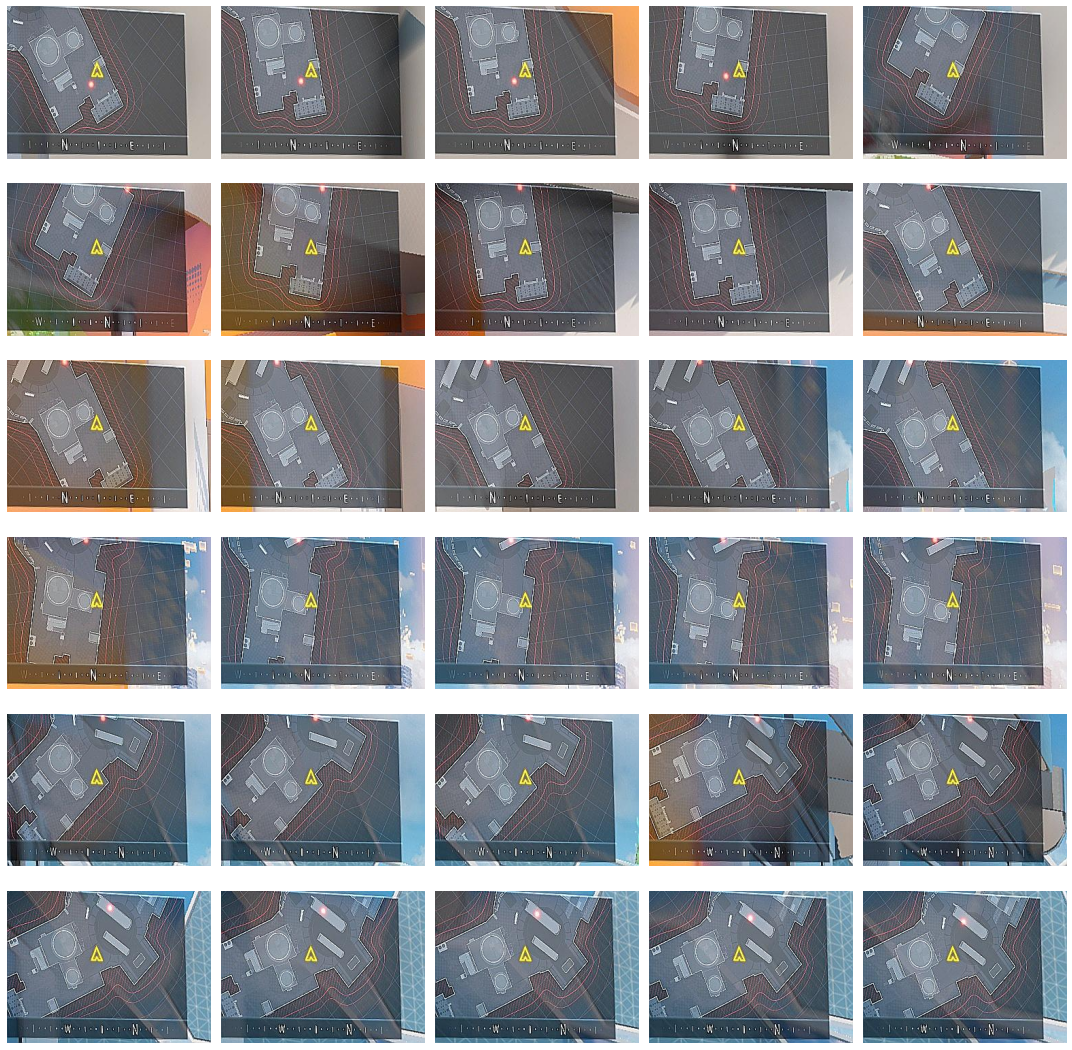

In [16]:
df_mostrar = df_train[df_train['id'] == np.random.randint(0, df_train['id'].nunique())]

posicion_x = 0  # Start from beginning
filas = min(8, len(df_mostrar))  # Use either 8 or the number of rows we have, whichever is smaller
print(f"Number of rows in df_mostrar: {len(df_mostrar)}")

fig, axes = plt.subplots(filas, 5, figsize=(15, 15))

for i in range(filas):
    for j in range(5):
        # Obtener la ruta de la imagen
        ruta_imagen = df_mostrar.iloc[i, (j+2)]  # Removed posicion_x offset
        
        # Abrir la imagen y convertirla a matriz numpy
        imagen = Image.open("../" + ruta_imagen)
        matriz_np = np.array(imagen)
        
        # Mostrar la imagen en el subplot correspondiente
        axes[i, j].imshow(matriz_np)
        axes[i, j].axis('off')
    print(df_mostrar.iloc[i]["reward"])

plt.tight_layout()
plt.show()

In [17]:
df_mostrar

id orden                                            mapa_01  \
45897  3522     1  datos/grabacion/mapa_augmentation/imagen_13548...   
45898  3522     2  datos/grabacion/mapa_augmentation/imagen_13549...   
45899  3522     3  datos/grabacion/mapa_augmentation/imagen_13550...   
45900  3522     4  datos/grabacion/mapa_augmentation/imagen_13551...   
45901  3522     5  datos/grabacion/mapa_augmentation/imagen_13552...   
45902  3522     6  datos/grabacion/mapa_augmentation/imagen_13553...   

                                                 mapa_02  \
45897  datos/grabacion/mapa_augmentation/imagen_13548...   
45898  datos/grabacion/mapa_augmentation/imagen_13549...   
45899  datos/grabacion/mapa_augmentation/imagen_13550...   
45900  datos/grabacion/mapa_augmentation/imagen_13551...   
45901  datos/grabacion/mapa_augmentation/imagen_13552...   
45902  datos/grabacion/mapa_augmentation/imagen_13553...   

                                                 mapa_03  \
45897  datos/grabacion/mapa_augmentation/imagen_13548...   
45898  datos/grabacion/mapa_augmentation/imagen_13549...   
45899  datos/grabacion/mapa_augmentation/imagen_13550...   
45900  datos/grabacion/mapa_augmentation/imagen_13551...   
45901  datos/grabacion/mapa_augmentation/imagen_13552...   
45902  datos/grabacion/mapa_augmentation/imagen_13553...   

                                                 mapa_04  \
45897  datos/grabacion/mapa_augmentation/imagen_13548...   
45898  datos/grabacion/mapa_augmentation/imagen_13549...   
45899  datos/grabacion/mapa_augmentation/imagen_13550...   
45900  datos/grabacion/mapa_augmentation/imagen_13551...   
45901  datos/grabacion/mapa_augmentation/imagen_13552...   
45902  datos/grabacion/mapa_augmentation/imagen_13553...   

                                                 mapa_05  reward  label_0  \
45897  datos/grabacion/mapa_augmentation/imagen_13548...   0.940        0   
45898  datos/grabacion/mapa_augmentation/imagen_13549...   0.805        0   
45899  datos/grabacion/mapa_augmentation/imagen_13550...   0.685        1   
45900  datos/grabacion/mapa_augmentation/imagen_13551...   0.610        1   
45901  datos/grabacion/mapa_augmentation/imagen_13552...   0.555        0   
45902  datos/grabacion/mapa_augmentation/imagen_13553...   0.740        0   

       label_1  label_2  
45897        1        0  
45898        0        1  
45899        0        0  
45900        0        0  
45901        0        1  
45902        1        0

In [18]:
df_mostrar.iloc[0]

id                                                      3522
orden                                                      1
mapa_01    datos/grabacion/mapa_augmentation/imagen_13548...
mapa_02    datos/grabacion/mapa_augmentation/imagen_13548...
mapa_03    datos/grabacion/mapa_augmentation/imagen_13548...
mapa_04    datos/grabacion/mapa_augmentation/imagen_13548...
mapa_05    datos/grabacion/mapa_augmentation/imagen_13548...
reward                                                  0.94
label_0                                                    0
label_1                                                    1
label_2                                                    0
Name: 45897, dtype: object

In [19]:
def preparacion_datos_fila(row):
    # Lista para almacenar las matrices numpy
    mapas_list = []

    # Obtenemos todas las columnas con imagenes del DataFrame
    mapa_cols = [col for col in row.index if col.startswith('mapa_')]
    #Guardamos las imagenes en una lista
    for col in mapa_cols:
        imagen = Image.open("../" + row[col])
        imagen_np = np.array(imagen)
        mapas_list.append(imagen_np)
    
    # Obtener el reward
    reward = row.filter(like='reward').values
    return np.array(mapas_list),np.array(reward)


def prediccion_features_map(imgs_tensor,modelo_autoencoder):
    modelo_autoencoder.eval()
    # Generar la salida
    with torch.no_grad():
        # Convertir los arrays de NumPy a tensores de PyTorch
        input_images = torch.tensor(imgs_tensor, dtype=torch.float32)
        input_images = input_images.to('cuda').float()  # Mover a GPU
        features, _ = modelo_autoencoder(input_images)
        return features.reshape(features.size(0), -1) #Flatten() 


def preparacion_tensor_imgs(lista_img):
    #Tamaño obligatorio para el modelo
    sequence_length = 5
    image_height = 188
    image_width = 260
    # Initialize video tensor
    video = np.zeros((sequence_length, image_height, image_width, 3))
    
    # Process each image in the sequence
    for j in range(sequence_length):
        imagen = Image.fromarray((lista_img[j] * 255).astype(np.uint8))
        imagen = imagen.resize((image_width, image_height))
        ancho, alto = imagen.size
            
        imagen = np.array(imagen) / 255.0
        video[j] = imagen

    # Obtener el video
    video_tensor = torch.tensor(video, dtype=torch.float32)
    video_tensor = video_tensor.unsqueeze(0)  # Ahora tendrá forma (1, T, H, W, C)
    video_tensor = video_tensor.permute(0, 4, 1, 2, 3)  # Reorganizar las dimensiones
    video_tensor = video_tensor.to('cuda').float()
    return video_tensor

def montar_tensor_entrada_imagenes(features_map):
    # Crear un tensor de ceros con la forma deseada
    sequence_length = 31
    features_padded = torch.zeros(1, sequence_length, 261120)
    # Copiar las características en la primera posición
    features_padded[0, 0, :] = features_map
    return features_padded

def montar_tensor_entrada_reward(reward_np):
    # Crear un tensor de ceros con la forma deseada
    sequence_length = 31
    # Convertir el array de recompensas a un tensor de PyTorch
    reward_tensor = torch.tensor(reward_np.astype(np.float32), dtype=torch.float32)
    # Crear un tensor de ceros con la forma deseada
    reward_padded = torch.zeros(1, sequence_length)
    # Copiar la recompensa en la primera posición
    reward_padded[0, 0] = reward_tensor
    return reward_padded


In [111]:
import torch
from torch import nn
from torch.optim import AdamW
from transformers import DecisionTransformerConfig, DecisionTransformerModel

class DecisionTransformerInferencia:
    def __init__(self, ruta_decision, ruta_autoencoder):
        self._cargarAutoencoder(ruta_autoencoder)
        self._cargarDecisionTransformer(ruta_decision)
    
    def _cargarDecisionTransformer(self, ruta_decision):
        # Configurar el modelo
        config = DecisionTransformerConfig(
            state_dim=261120,
            act_dim=3,
            hidden_size=250,
            max_ep_len=31,  # Longitud máxima del episodio
            n_layer=2,
            n_head=2,
            hidden_dropout_prob=0.3, 
            scale_attn_weights=True,  # Escalar los pesos de atención
            use_cache=True            # Si usar cache para optimizar el cálculo de las atenciones
        )
        self.modelo_decision = DecisionTransformerModel(config).to('cuda')

        # Cargar los pesos del modelo desde el archivo .pth
        self.modelo_decision.load_state_dict(torch.load(ruta_decision))

    def _cargarAutoencoder(self, ruta_autoencoder):
        # Cargar modelo autoencoder
        input_shape_pov = (3, 5, 188, 260)  # Ejemplo de forma de entrada (canales, pasos de tiempo, alto, ancho)
        self.modelo_autoencoder = AutoEncoder(input_shape_pov).to('cuda')  # Instancia el modelo y lo envía a la GPU
        self.modelo_autoencoder.load_state_dict(torch.load(ruta_autoencoder))  # Cargar los pesos
        
    def _preparacion_datos_fila(self, row): 
        # Lista para almacenar las matrices numpy
        mapas_list = []

        # Obtenemos todas las columnas con imágenes del DataFrame
        mapa_cols = [col for col in row.index if col.startswith('mapa_')]
        # Guardamos las imágenes en una lista
        for col in mapa_cols:
            imagen = Image.open("../" + row[col])
            imagen_np = np.array(imagen) / 255.0 
            mapas_list.append(imagen_np)
        
        # Obtener el reward
        reward = row.filter(like='reward').values
        return np.array(mapas_list), np.array(reward)

    def _prediccion_features_map(self, imgs_tensor):
        self.modelo_autoencoder.eval()
        # Generar la salida
        with torch.no_grad():
            # Convertir los arrays de NumPy a tensores de PyTorch
            input_images = torch.tensor(imgs_tensor, dtype=torch.float32).to('cuda')
            features, _ = self.modelo_autoencoder(input_images)
            return features.reshape(features.size(0), -1)  # Flatten

    def _preparacion_tensor_imgs(self, lista_img):
        # Tamaño obligatorio para el modelo
        sequence_length = 5
        image_height = 188
        image_width = 260
        # Initialize video tensor
        video = np.zeros((sequence_length, image_height, image_width, 3))
        
        # Process each image in the sequence
        for j in range(sequence_length):
            imagen = Image.fromarray((lista_img[j] * 255).astype(np.uint8))
            imagen = imagen.resize((image_width, image_height))
            imagen = np.array(imagen) / 255.0
            video[j] = imagen

        return video
        # Obtener el video
        #video_tensor = torch.tensor(video, dtype=torch.float32).unsqueeze(0)  # Ahora tendrá forma (1, T, H, W, C)
        #video_tensor = video_tensor.permute(0, 4, 1, 2, 3).to('cuda').float()  # Reorganizar las dimensiones
        #return video_tensor

    def _montar_tensor_entrada_imagenes(self , features_map):
        real_size = features_map.shape[0]
        # Crear un tensor de ceros para el padding
        padding = torch.zeros((31 - real_size, 261120)).to('cuda')
        # Concatenar el tensor original con el tensor de ceros
        padded_features_map = torch.cat((features_map, padding), dim=0)
        return padded_features_map

    def _montar_tensor_entrada_reward(self, reward_np):
        # Convertir el array de recompensas a un tensor de PyTorch
        reward_tensor = torch.tensor(reward_np.astype(np.float32), dtype=torch.float32).to('cuda')
        # Crear un tensor de ceros con la forma [27, 1] para el padding
        padding = torch.zeros((31 - reward_np.shape[0], 1)).to('cuda')
        # Concatenar el tensor original con el tensor de ceros
        padded_reward_tensor = torch.cat((reward_tensor, padding), dim=0)
        return padded_reward_tensor
    
    def _crear_attention_mask(self, tamano_original, tamano_maximo):
        # Crear una máscara con 1s para los datos reales
        attention_mask = torch.zeros(tamano_maximo, dtype=torch.float32).to('cuda')
        attention_mask[:tamano_original] = 1  # Marcar como "válido" las posiciones reales
        return attention_mask

    def _prediccion_DecisionTransformer(self, tensor_imgs, tensor_reward):
        # Mover datos a GPU si está disponible
        tensor_imgs = tensor_imgs.to('cuda')
        tensor_reward = tensor_reward.to('cuda')
        
        # Crear una máscara de atención (1s para posiciones válidas, 0s para padding)
        attention_mask_tensor = self._crear_attention_mask(tamano_original=1, tamano_maximo=31).unsqueeze(0)
        
        # Calcular returns-to-go
        returns_to_go = torch.zeros_like(tensor_reward)
        for t in range(tensor_reward.size(1)):
            returns_to_go[:, t] = tensor_reward[:, t:].sum(dim=1)
        returns_to_go = returns_to_go.unsqueeze(-1)  # Ajuste dimensional

        # Poner el modelo en modo de evaluación
        self.modelo_decision.eval()
        
        # Forward pass
        with torch.no_grad():
            outputs = self.modelo_decision(
                states=tensor_imgs,
                actions=torch.zeros(1, 31, 3).to('cuda'),  # Acciones vacías como placeholder
                rewards=tensor_reward,
                returns_to_go=returns_to_go,  # Informa al modelo de recompensas futuras
                timesteps=torch.arange(tensor_imgs.shape[1]).unsqueeze(0).repeat(tensor_imgs.shape[0], 1).to('cuda'),
                attention_mask=attention_mask_tensor.permute(1, 0)  # Transponer para que quede en forma [seq_len, batch_size]
            )

        # Predicciones: Obtenemos las acciones predichas (usando argmax)
        predicted_actions = torch.argmax(outputs.action_preds, dim=-1)  # Índices de las clases predichas
        
        return predicted_actions
    
    def prediccion_fila_pandas(self, row):
        # Preparación datos a np
        lista_img, lista_reward = self._preparacion_datos_fila(row)
        # Pasar arrays np a tensores
        tensor_imgs = self._preparacion_tensor_imgs(lista_img)
        # Obtención espacio latente
        features_map = self._prediccion_features_map(tensor_imgs)

        tensor_imgs = self._montar_tensor_entrada_imagenes(features_map)
        # Pasar np a tensores
        tensor_reward = self._montar_tensor_entrada_reward(lista_reward)
        # Predicción final
        prediccion_accion = self._prediccion_DecisionTransformer(tensor_imgs, tensor_reward)
        return prediccion_accion[0][0]

In [112]:
inferencia = DecisionTransformerInferencia("Decisiontransform_model_no_reward.pth","modelo_autoencoder_245_final.pth")

/tmp/ipykernel_7393/377679567.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.modelo_autoencoder.load_state_dict(torch.load(ruta_autoencoder))  # Cargar los pesos


In [27]:
df_mostrar

id orden                                            mapa_01  \
45897  3522     1  datos/grabacion/mapa_augmentation/imagen_13548...   
45898  3522     2  datos/grabacion/mapa_augmentation/imagen_13549...   
45899  3522     3  datos/grabacion/mapa_augmentation/imagen_13550...   
45900  3522     4  datos/grabacion/mapa_augmentation/imagen_13551...   
45901  3522     5  datos/grabacion/mapa_augmentation/imagen_13552...   
45902  3522     6  datos/grabacion/mapa_augmentation/imagen_13553...   

                                                 mapa_02  \
45897  datos/grabacion/mapa_augmentation/imagen_13548...   
45898  datos/grabacion/mapa_augmentation/imagen_13549...   
45899  datos/grabacion/mapa_augmentation/imagen_13550...   
45900  datos/grabacion/mapa_augmentation/imagen_13551...   
45901  datos/grabacion/mapa_augmentation/imagen_13552...   
45902  datos/grabacion/mapa_augmentation/imagen_13553...   

                                                 mapa_03  \
45897  datos/grabacion/mapa_augmentation/imagen_13548...   
45898  datos/grabacion/mapa_augmentation/imagen_13549...   
45899  datos/grabacion/mapa_augmentation/imagen_13550...   
45900  datos/grabacion/mapa_augmentation/imagen_13551...   
45901  datos/grabacion/mapa_augmentation/imagen_13552...   
45902  datos/grabacion/mapa_augmentation/imagen_13553...   

                                                 mapa_04  \
45897  datos/grabacion/mapa_augmentation/imagen_13548...   
45898  datos/grabacion/mapa_augmentation/imagen_13549...   
45899  datos/grabacion/mapa_augmentation/imagen_13550...   
45900  datos/grabacion/mapa_augmentation/imagen_13551...   
45901  datos/grabacion/mapa_augmentation/imagen_13552...   
45902  datos/grabacion/mapa_augmentation/imagen_13553...   

                                                 mapa_05  reward  label_0  \
45897  datos/grabacion/mapa_augmentation/imagen_13548...   0.940        0   
45898  datos/grabacion/mapa_augmentation/imagen_13549...   0.805        0   
45899  datos/grabacion/mapa_augmentation/imagen_13550...   0.685        1   
45900  datos/grabacion/mapa_augmentation/imagen_13551...   0.610        1   
45901  datos/grabacion/mapa_augmentation/imagen_13552...   0.555        0   
45902  datos/grabacion/mapa_augmentation/imagen_13553...   0.740        0   

       label_1  label_2  
45897        1        0  
45898        0        1  
45899        0        0  
45900        0        0  
45901        0        1  
45902        1        0

In [57]:
imagenes_np = np.empty((0, 5, 225, 300, 3))
rewards_np = np.empty((0, 1))
i = 0
# Recorrer las filas del DataFrame
for index, row in df_mostrar.iterrows():
    i = i + 1
    lista_img, lista_reward = inferencia._preparacion_datos_fila(row)
    # Agregar los valores a los arrays de NumPy
    imagenes_np = np.append(imagenes_np, [lista_img], axis=0)
    rewards_np = np.append(rewards_np, [lista_reward], axis=0)
    if i == 4:
        break

In [62]:
imagenes_np[0].shape

(5, 225, 300, 3)

In [61]:
rewards_np.shape

(4, 1)

In [69]:
imagenes_tensor = []

for i in range(imagenes_np.shape[0]):
    tensor_img = inferencia._preparacion_tensor_imgs(imagenes_np[i])
    imagenes_tensor.append(tensor_img)

# Convertir la lista de tensores a un array de NumPy
imagenes_tensor_np = np.array(imagenes_tensor)
# Transponer el array de NumPy para que tenga el formato (N, T, C, H, W)
imagenes_tensor_np = np.transpose(imagenes_tensor_np, (0, 4, 1, 2, 3))
# Convertir el array de NumPy a un tensor de PyTorch
imagenes_tensor_torch = torch.from_numpy(imagenes_tensor_np).float().to('cuda')

(4, 5, 188, 260, 3)


In [89]:
# Transponer el array de NumPy para que tenga el formato (N, T, C, H, W)
imagenes_tensor_np = np.transpose(imagenes_tensor_np, (0, 4, 1, 2, 3))
# Convertir el array de NumPy a un tensor de PyTorch
imagenes_tensor_torch = torch.from_numpy(imagenes_tensor_np).float().to('cuda')

In [90]:
imagenes_tensor_torch.shape

torch.Size([4, 3, 5, 188, 260])

In [91]:
features_map = inferencia._prediccion_features_map(imagenes_tensor_torch)

/tmp/ipykernel_7393/3459001940.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_images = torch.tensor(imgs_tensor, dtype=torch.float32).to('cuda')


In [92]:
features_map.shape

torch.Size([4, 261120])

In [97]:
features_map

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2252],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1348, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2782, 0.3445],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0501, 0.0000]],
       device='cuda:0')

In [98]:
tensor_imgs = inferencia._montar_tensor_entrada_imagenes(features_map)

In [103]:
tensor_imgs

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2252],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1348, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2782, 0.3445],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [113]:
tensor_reward = inferencia._montar_tensor_entrada_reward(rewards_np)

In [115]:
tensor_reward

tensor([[0.9400],
        [0.8050],
        [0.6850],
        [0.6100],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000]], device='cuda:0')

In [ ]:
prediccion_accion = self._prediccion_DecisionTransformer(tensor_imgs, tensor_reward)

In [98]:
lista_img,lista_reward = preparacion_datos_fila(df_mostrar.iloc[0])

In [107]:
lista_reward

array([0.965], dtype=object)

In [99]:
lista_img.shape

(5, 225, 300, 3)

In [101]:
tensor_imgs = preparacion_tensor_imgs(lista_img)

In [102]:
tensor_imgs.shape

torch.Size([1, 3, 5, 188, 260])

In [105]:
batch_size = 20
max_episodo_len = 31

# Cargar modelo autoencoder
input_shape_pov = (3, 5, 188, 260)  # Ejemplo de forma de entrada (canales, pasos de tiempo, alto, ancho)
model = AutoEncoder(input_shape_pov).to('cuda')  # Instancia el modelo y lo envía a la GPU
model.load_state_dict(torch.load('modelo_autoencoder_245_final.pth'))  # Cargar los pesos

features_map = prediccion_features_map(tensor_imgs,model)

/tmp/ipykernel_89570/635889588.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('modelo_autoencoder_245_final.pth'))  # Cargar los pesos


In [106]:
features_map.shape

torch.Size([1, 261120])

In [118]:
tensor_final = montar_tensor_entrada(features_map)

In [119]:
tensor_final.shape

torch.Size([1, 31, 261120])

In [134]:
tensor_final[0]

tensor([[0.0000, 0.0000, 0.0000,  ..., 1.3468, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [130]:
tensor_reward = montar_tensor_entrada_reward(lista_reward)

In [131]:
tensor_reward.shape

torch.Size([1, 31])

In [133]:
tensor_reward[0]

tensor([0.9650, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])

In [ ]:
import torch

def prediccion_DecisionTransformer(tensor_imgs, tensor_reward, modelo_decision):
    # Mover datos a GPU si está disponible
    tensor_imgs = tensor_imgs.to('cuda')
    tensor_reward = tensor_reward.to('cuda')
    
    # Crear una máscara de atención (1s para posiciones válidas, 0s para padding)
    attention_mask_tensor = torch.ones(tensor_imgs.size(0), tensor_imgs.size(1)).to('cuda')
    
    # Calcular returns-to-go
    returns_to_go = torch.zeros_like(tensor_reward)
    for t in range(tensor_reward.size(1)):
        returns_to_go[:, t] = tensor_reward[:, :t+1].sum(dim=1)
    returns_to_go = returns_to_go.unsqueeze(-1)  # Ajuste dimensional

    # Poner el modelo en modo de evaluación
    modelo_decision.eval()
    
    # Forward pass
    with torch.no_grad():
        outputs = modelo_decision(
            states=tensor_imgs,
            actions=None,  # No pasamos acciones
            rewards=tensor_reward,
            returns_to_go=returns_to_go,  # Informa al modelo de recompensas futuras
            timesteps=torch.arange(tensor_imgs.shape[1]).unsqueeze(0).repeat(tensor_imgs.shape[0], 1).to('cuda'),
            attention_mask=attention_mask_tensor.permute(1, 0)  # Transponer para que quede en forma [seq_len, batch_size]
        )

    # Predicciones: Obtenemos las acciones predichas (usando argmax)
    predicted_actions = torch.argmax(outputs.action_preds, dim=-1)  # Índices de las clases predichas
    
    return predicted_actions

# Ejemplo de uso
# tensor_imgs y tensor_reward deben ser tensores de PyTorch con las formas adecuadas
# modelo_decision es una instancia de DecisionTransformerModel cargada con los pesos entrenados
acciones = prediccion_DecisionTransformer(tensor_imgs, tensor_reward, model)
print(acciones)